In [296]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import keras
import seaborn as sns

In [297]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [298]:
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.1,
    subset="both",
    seed=1337,
    batch_size=batch_size,
)

Found 974 files belonging to 2 classes.
Using 877 files for training.
Using 97 files for validation.


In [299]:
data_iterator = train_ds.as_numpy_iterator()

In [300]:
#Gets another batch of 32 images and labels
batch = data_iterator.next()

In [301]:
#Labels for images
batch[1].shape

(128,)

In [302]:
#Images represented as numpy arrays
batch[0].shape

(128, 256, 256, 3)

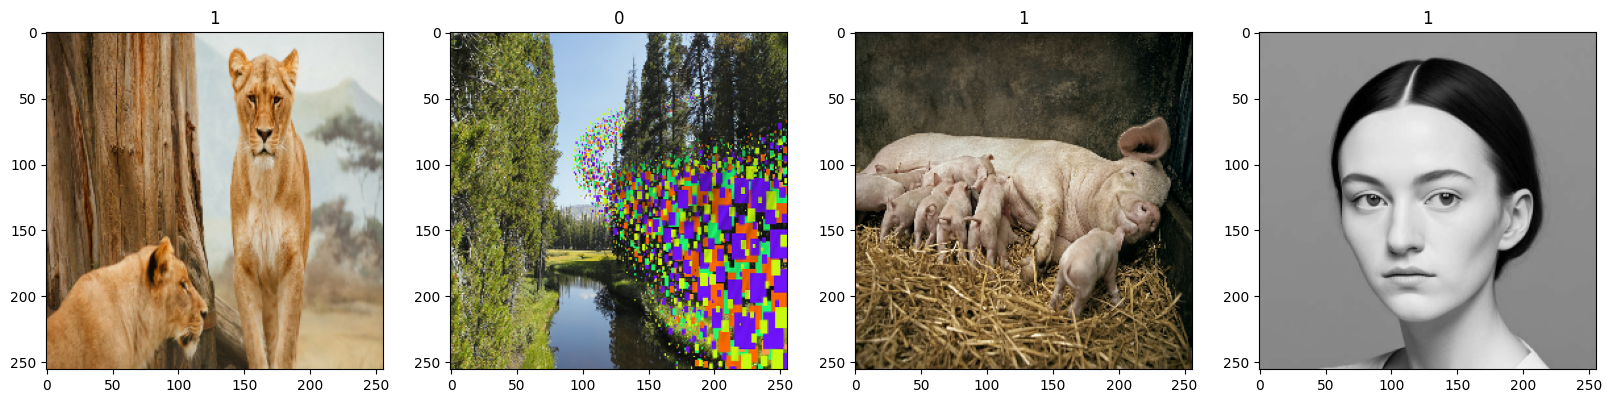

In [303]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) 

#Class 1 = AI
#Class 0 = Real

In [304]:
#data = data.map(lambda x,y: (x/255, y))
train_ds = val_ds.map(lambda x,y: (x/255, y))
val_ds  = val_ds.map(lambda x,y: (x/255, y))

In [305]:
#train_size = int(len(data)*.7)+1
#val_size = int(len(data)*.2)
#test_size = int(len(data)*.1)

In [306]:
#train = data.take(train_size)
#val = data.skip(train_size).take(val_size)
#test = data.skip(train_size + val_size).take(test_size)

In [307]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [308]:
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())
#model.add(Dropout(0.10))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
#model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(1, activation = 'sigmoid'))

In [309]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [310]:
model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [311]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [312]:
#One Epoch is a complete iteration of the entire dataset. During each epoch, the cnn updates its weights and biases.
epochs = 100  
#Batch size is the number of training examples the cnn processes at oncee before updating its weights.
batch_size = 250

In [313]:
'''
# Data augmentation is used in CNN's to increase the amount and diversity of the training data without actually collecting new data.
# It is done by applying a variety of transformations to existing training data, such as rotation, scaling, flipping, and cropping
# Done to create new versions of the same image
# Beneficial since it improves performance and generalization of CNN's by increasing diversity and amount of training data
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=5,  #Range from 0-180 degrees which to randomly rotate pictures. 
        zoom_range = 0.1, #Randomly zoom into pictures
        width_shift_range=0.1,  #Randomly translates image from 0-10% width direction
        height_shift_range=0.1,  #Randomly translates image from 0-10% height direction
        horizontal_flip=False,  #Don't flip image (probably since we are dealing with integers)
        vertical_flip=False)  

datagen.fit(train_ds)
'''

"\n# Data augmentation is used in CNN's to increase the amount and diversity of the training data without actually collecting new data.\n# It is done by applying a variety of transformations to existing training data, such as rotation, scaling, flipping, and cropping\n# Done to create new versions of the same image\n# Beneficial since it improves performance and generalization of CNN's by increasing diversity and amount of training data\ndatagen = ImageDataGenerator(\n        featurewise_center=False,  \n        samplewise_center=False, \n        featurewise_std_normalization=False,  \n        samplewise_std_normalization=False,  \n        zca_whitening=False, \n        rotation_range=5,  #Range from 0-180 degrees which to randomly rotate pictures. \n        zoom_range = 0.1, #Randomly zoom into pictures\n        width_shift_range=0.1,  #Randomly translates image from 0-10% width direction\n        height_shift_range=0.1,  #Randomly translates image from 0-10% height direction\n       

In [314]:
#Logger resultatene
from tensorflow.keras.callbacks import EarlyStopping
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=6)

my_callbacks = [
    tensorboard_callback,
    early_stopping
]

history = model.fit(train_ds, epochs= epochs, callbacks=my_callbacks, validation_data=val_ds)

Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4948 - loss: 0.7125 - val_accuracy: 0.5052 - val_loss: 1.5543
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5052 - loss: 1.5543 - val_accuracy: 0.5052 - val_loss: 0.6960
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5052 - loss: 0.6960 - val_accuracy: 0.4948 - val_loss: 0.7248
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4948 - loss: 0.7248 - val_accuracy: 0.4948 - val_loss: 0.7260
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4948 - loss: 0.7260 - val_accuracy: 0.4948 - val_loss: 0.7033
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4948 - loss: 0.7033 - val_accuracy: 0.5052 - val_loss: 0.6881
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5052 - loss: 0.6881 - val_accuracy: 0.5155 - val_loss: 0.6794
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5155 - loss: 0.6794 - val_accuracy: 0.8247 - val_loss: 0.6725
Epoch 9/100
1/1 ━━━━

In [315]:
history.history

{'accuracy': [0.49484536051750183,
  0.5051546096801758,
  0.5051546096801758,
  0.49484536051750183,
  0.49484536051750183,
  0.49484536051750183,
  0.5051546096801758,
  0.5154638886451721,
  0.8247422575950623,
  0.7938144207000732,
  0.8247422575950623,
  0.7319587469100952,
  0.7319587469100952,
  0.7835051417350769,
  0.8247422575950623,
  0.7938144207000732,
  0.8144329786300659,
  0.8247422575950623,
  0.8247422575950623,
  0.8350515365600586,
  0.8556700944900513,
  0.8659793734550476,
  0.876288652420044,
  0.876288652420044,
  0.9175257682800293,
  0.9175257682800293,
  0.9175257682800293,
  0.9278350472450256,
  0.9587628841400146,
  0.969072163105011,
  0.9587628841400146,
  0.969072163105011,
  0.9793814420700073,
  0.969072163105011,
  1.0,
  1.0,
  0.9896907210350037,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  

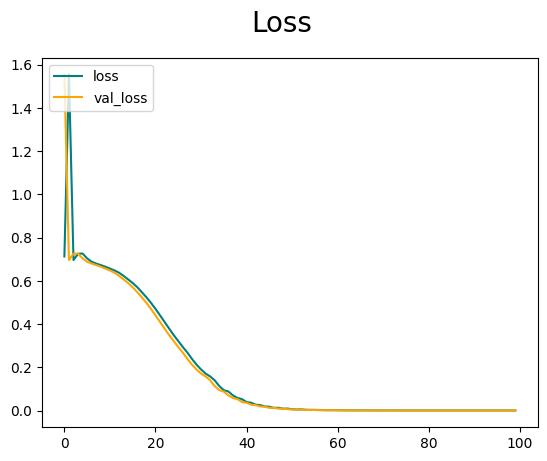

In [316]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

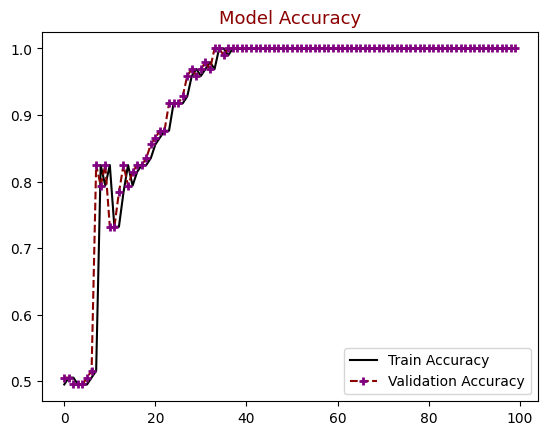

In [317]:
# Model Accuracy 

plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy", color = "darkred", marker = "+", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


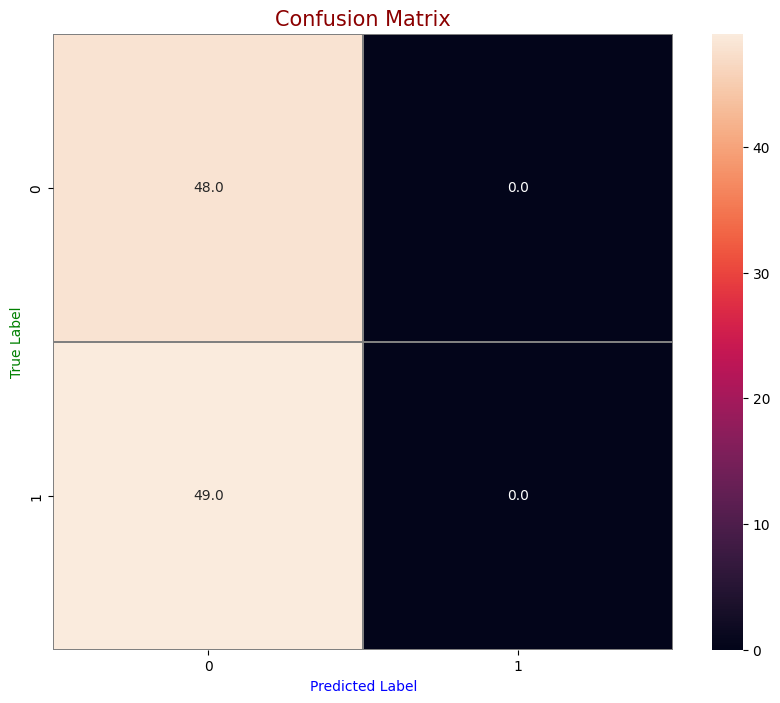

In [319]:
for images, labels in train_ds.take(1):
    val_lab = (np.array(labels).astype("uint8"))

# We make predictions using the model we have created.
Y_pred = model.predict(val_ds)
# argmax = To briefly mention it, it will give the index of the value with the highest value.
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

# We do the same for the y_val values. because we will compare these values. 
#Y_true = np.argmax(val_lab) 
Y_true = val_lab
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label", color = "blue")
plt.ylabel("True Label", color = "green")
plt.title("Confusion Matrix", color = "darkred", size = 15)
plt.show()

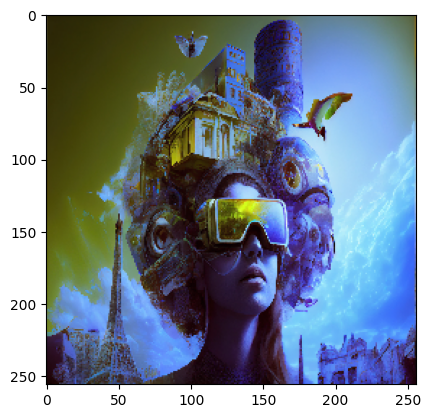

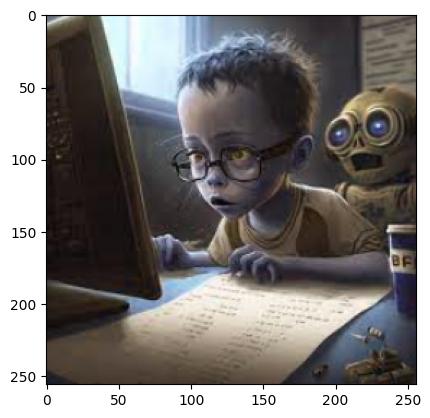

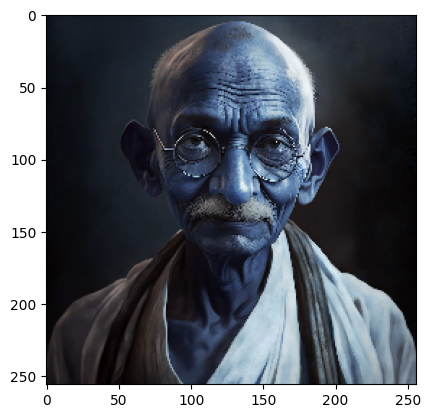

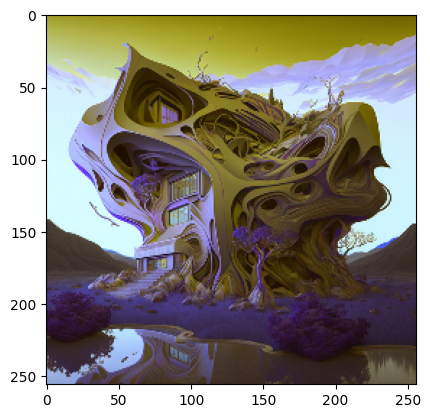

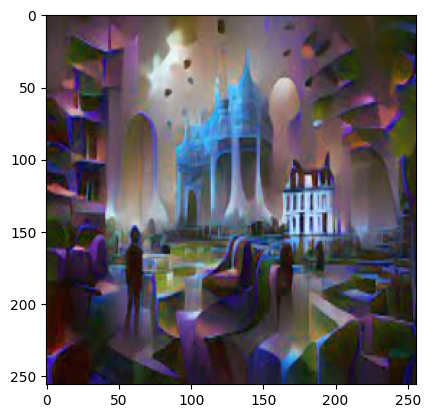

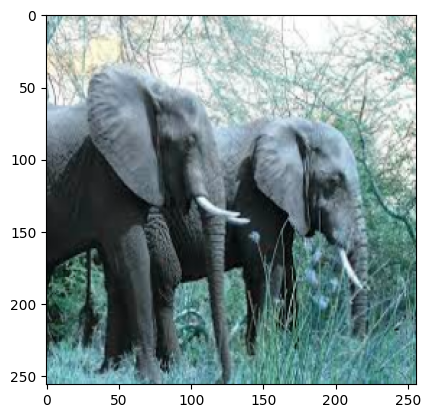

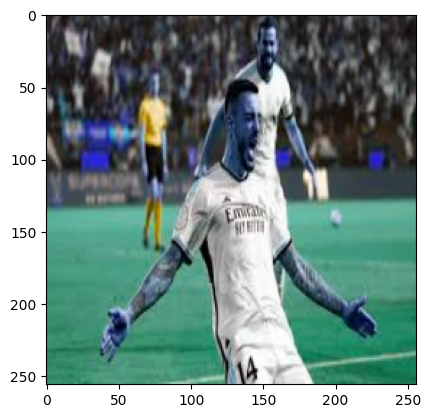

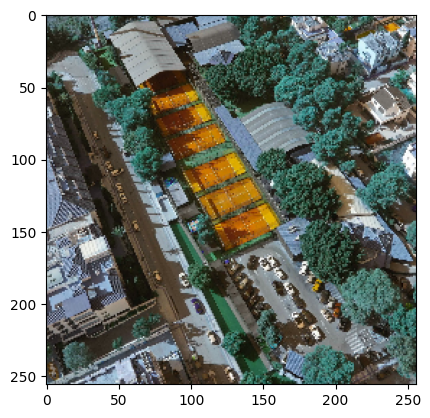

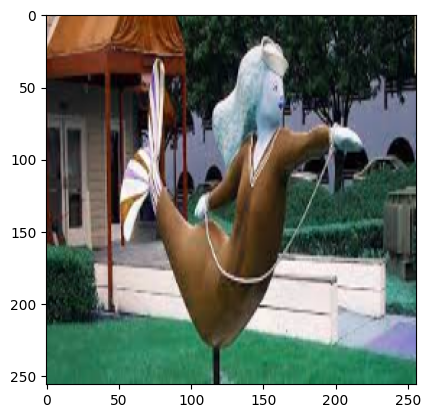

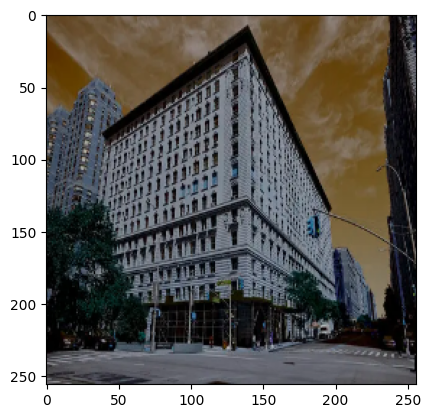

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted class for test_images\ai.jpg is AI art
[[0.18504]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The predicted class for test_images\ai1.jpg is real art
[[0.9998307]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The predicted class for test_images\ai2.jpg is AI art
[[2.4354285e-09]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The predicted class for test_images\ai3.jpg is real art
[[0.9781719]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The predicted class for test_images\AItest.jpg is AI art
[[0.00019477]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted class for test_images\real.jpg is real art
[[0.90554655]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted class for test_images\real1.jpg is real art
[[0.99633956]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The predicted class for test_images\real2.jpg is AI art
[[2.8320881e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted class for test_images\real3.jpg is AI art
[[0.03615104]]
1/1 ━━━━━━━━━━━━━━━

In [323]:
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Get a list of file paths for all JPEG images in the folder
image_paths = glob.glob('test_images/*.jpg')

# Display images
for img_path in image_paths:
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    
    # Check if the image was read successfully
    if img is not None:
        # Resize the image using TensorFlow
        resize = tf.image.resize(img, (256, 256))
        
        # Display the resized image
        plt.imshow(resize.numpy().astype(int))
        plt.show()
    else:
        print(f"Error reading image: {img_path}")

# Show predictions


for img_path in image_paths:
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    
    # Check if the image was read successfully
    if img is not None:
        # Resize the image using TensorFlow
        resize = tf.image.resize(img, (256, 256))
        
        # Normalize the resized image
        resized_normalized = resize / 255.0
        
        # Expand dimensions to match model input shape
        resized_normalized_expanded = np.expand_dims(resized_normalized, axis=0)
        
        # Model prediction
        prediction = model.predict(resized_normalized_expanded)
        
        # Evaluate prediction
        if prediction > 0.5:
            print('The predicted class for', img_path, 'is real art')
            print(prediction)
        else:
            print('The predicted class for', img_path, 'is AI art')
            print(prediction)
        
        
    else:
        print(f"Error reading image: {img_path}")